# Assignment 1 (Tyler Wilson)

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# 1 - Getting Started

Load data

In [41]:
amp_data = np.load('DATA/amp_data.npz')['amp_data']

Plot data

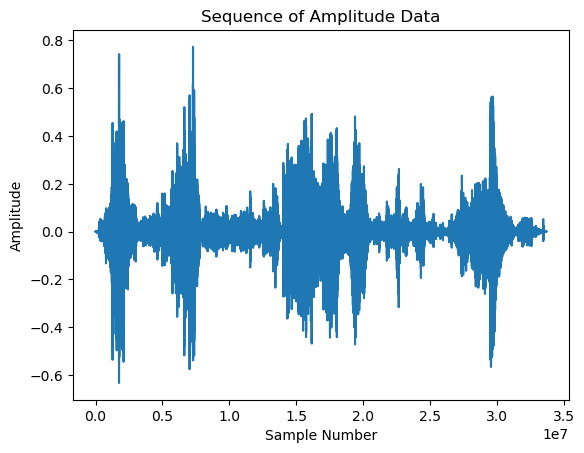

In [42]:
# plot line graph of data
plt.plot(amp_data)
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.title('Sequence of Amplitude Data')
plt.show()

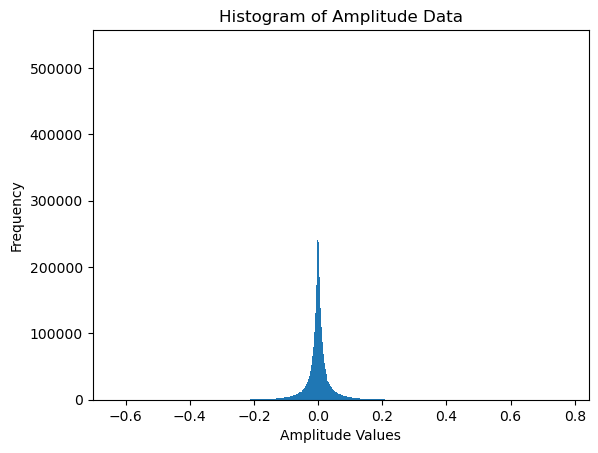

In [43]:
# plot histogram of data
N_points = len(amp_data)
N_bins = int(np.sqrt(N_points))
plt.hist(amp_data, bins=N_bins)
plt.xlabel('Amplitude Values')
plt.ylabel('Frequency')
plt.title('Histogram of Amplitude Data')
plt.show()

Reshape the data into a matrix

In [44]:
num_columns = 21
num_rows = len(amp_data) // num_columns
amp_data_matrix = np.reshape(amp_data[:num_rows * num_columns], (num_rows, num_columns))
print(f'shape is {amp_data_matrix.shape}')

shape is (1605394, 21)


Shuffle and split the data

In [45]:
train_split = 0.7
val_split = 0.15
test_split = 0.15
# verify that the partitions add up to 1
assert train_split + val_split + test_split == 1

In [46]:
# shuffle the rows of the matrix
np.random.seed(42) #seed number 42
np.random.permutation(amp_data_matrix)
# partition the data into training, validation, and test sets
X_shuf_train = amp_data_matrix[:int(train_split * num_rows), :num_columns - 1]
y_shuf_train = amp_data_matrix[:int(train_split * num_rows), num_columns - 1]
X_shuf_val = amp_data_matrix[int(train_split * num_rows):int((train_split + val_split) * num_rows), :num_columns - 1]
y_shuf_val = amp_data_matrix[int(train_split * num_rows):int((train_split + val_split) * num_rows), num_columns - 1]
X_shuf_test = amp_data_matrix[int((train_split + val_split) * num_rows):, :num_columns - 1]
y_shuf_test = amp_data_matrix[int((train_split + val_split) * num_rows):, num_columns - 1]

# save the datasets
np.save('DATA/X_shuf_train.npy', X_shuf_train)
np.save('DATA/y_shuf_train.npy', y_shuf_train)
np.save('DATA/X_shuf_val.npy', X_shuf_val)
np.save('DATA/y_shuf_val.npy', y_shuf_val)
np.save('DATA/X_shuf_test.npy', X_shuf_test)
np.save('DATA/y_shuf_test.npy', y_shuf_test)

# 2 - Curve fitting on a snippet of audio

In [47]:
# load training data
X_shuf_train = np.load('DATA/X_shuf_train.npy')
y_shuf_train = np.load('DATA/y_shuf_train.npy')

# create time data
time_data_ext = np.arange(0, 21, 1) / 20
time_data = time_data_ext[:20]

Plot of data vs. time

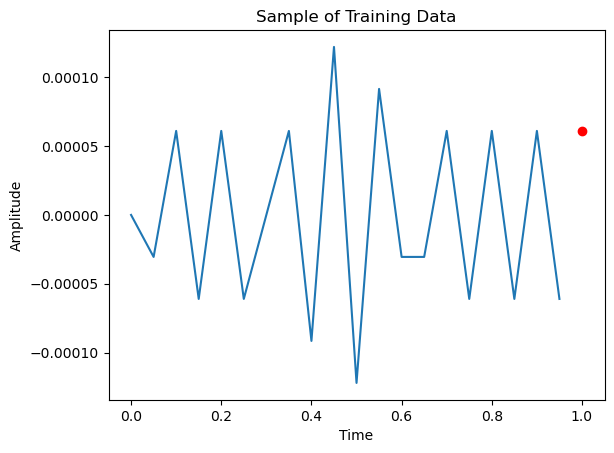

In [48]:
# plot the data vs time
sample_data = X_shuf_train[0]
sample_point = y_shuf_train[0]
plt.plot(time_data, sample_data)
plt.plot(time_data_ext[-1], sample_point, 'ro')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sample of Training Data')
plt.show()

In [49]:
# compute the weights for the linear model
design_matrix_linear = np.vstack([time_data, np.ones(len(sample_data))]).T
m, b = np.linalg.lstsq(design_matrix_linear, sample_data, rcond=None)[0]

# compute the weights for the quartic model
design_matrix_quartic = np.vstack([time_data**4, time_data**3, time_data**2, time_data, np.ones(len(sample_data))]).T
weights = np.linalg.lstsq(design_matrix_quartic, sample_data, rcond=None)[0]

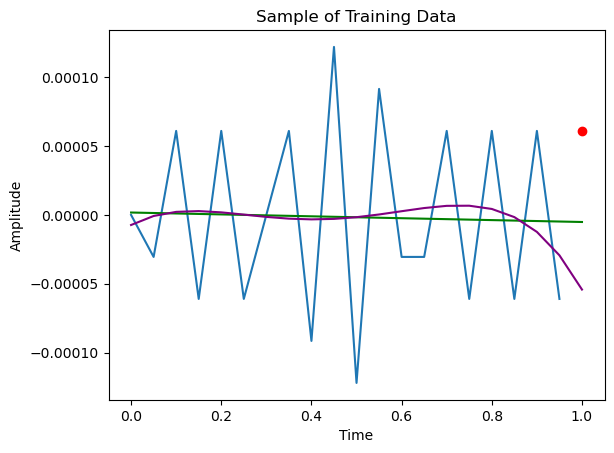

In [50]:
# plot the models vs time
sample_data = X_shuf_train[0]
sample_point = y_shuf_train[0]
plt.plot(time_data, sample_data)
plt.plot(time_data_ext, m * time_data_ext + b, 'g')
plt.plot(time_data_ext, np.polyval(weights, time_data_ext), 'purple')
plt.plot(1, sample_point, 'ro')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Sample of Training Data')
plt.show()

# 3 - Choosing a polynomial predictor based on performance

In [51]:
# load training data
X_shuf_train = np.load('DATA/X_shuf_train.npy')
y_shuf_train = np.load('DATA/y_shuf_train.npy')

# create time data
time_data_ext = np.arange(0, 21, 1) / 20
time_data = time_data_ext[:20]

In [52]:
def Phi(C, K):
    # create time data
    time_data_ext = np.arange(0, 21, 1) / 20
    time_data = time_data_ext[:20]
    recent_times = time_data[len(time_data) - C:]
    return (recent_times ** np.arange(0,K)[:, np.newaxis]).T

Phi(10,5)

array([[1.        , 0.5       , 0.25      , 0.125     , 0.0625    ],
       [1.        , 0.55      , 0.3025    , 0.166375  , 0.09150625],
       [1.        , 0.6       , 0.36      , 0.216     , 0.1296    ],
       [1.        , 0.65      , 0.4225    , 0.274625  , 0.17850625],
       [1.        , 0.7       , 0.49      , 0.343     , 0.2401    ],
       [1.        , 0.75      , 0.5625    , 0.421875  , 0.31640625],
       [1.        , 0.8       , 0.64      , 0.512     , 0.4096    ],
       [1.        , 0.85      , 0.7225    , 0.614125  , 0.52200625],
       [1.        , 0.9       , 0.81      , 0.729     , 0.6561    ],
       [1.        , 0.95      , 0.9025    , 0.857375  , 0.81450625]])

In [53]:
def make_vv(C, K):
    phi = Phi(C, K)
    newtime = ([1] ** np.arange(0,K)[:, np.newaxis])
    return np.matmul(np.matmul(phi, np.linalg.inv(np.matmul(phi.T, phi))), newtime)
make_vv(10,5)

array([[ 0.5       ],
       [-0.83333333],
       [-0.41666666],
       [ 0.41666667],
       [ 0.83333333],
       [ 0.5       ],
       [-0.41666667],
       [-1.25      ],
       [-0.83333333],
       [ 2.5       ]])

In [54]:
linear_fit = np.matmul((make_vv(20,2)).T, sample_data)
quartic_fit = np.matmul((make_vv(20,5)).T, sample_data)
print(linear_fit, quartic_fit)

[-5.13980263e-06] [-5.42246028e-05]


In [55]:
C_list = np.arange(1,20,1)
results = []

for c in C_list:
    X_shuf_train_recent = X_shuf_train[:,(20-c):]
    for k in range(1,c):
        print(X_shuf_train_recent.shape)
        print(make_vv(c,k).shape)
        pred = np.matmul(X_shuf_train_recent, make_vv(c,k))
        print(pred.shape)
        print(y_shuf_train.shape)
        se = (pred - y_shuf_train[:,np.newaxis])**2
        print(se.shape)
        results.append([c,k, np.mean(se)])
print(results)

(1123775, 2)
(2, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 3)
(3, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 3)
(3, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 4)
(4, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 4)
(4, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 4)
(4, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 5)
(5, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 5)
(5, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 5)
(5, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 5)
(5, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 6)
(6, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 6)
(6, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 6)
(6, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 6)
(6, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 6)
(6, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 7)
(7, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 7)
(7, 1)
(1123775, 1)
(1123775,)
(1123775, 1)
(1123775, 7)
(7, 1)
(1123775, 1

In [56]:
results[np.argmin([row[2] for row in results])]

[3, 2, 3.2094611768551814e-05]

In [57]:
X_shuf_val_recent = X_shuf_val[:,(20-3):]
y_pred_val = np.matmul(X_shuf_val_recent, make_vv(3,2))
val_se = (y_pred_val - y_shuf_val[:,np.newaxis])**2
print(f'MSE on validation set is {np.mean(val_se)}')

X_shuf_test_recent = X_shuf_test[:,(20-3):]
y_pred_test = np.matmul(X_shuf_test_recent, make_vv(3,2))
test_se = (y_pred_test - y_shuf_test[:,np.newaxis])**2
print(f'MSE on test set is {np.mean(test_se)}')

MSE on validation set is 4.659672020180417e-06
MSE on test set is 1.0503073613201032e-05


# 4 - Fitting linear predictors across many snippets